# Skin Lesion Classification with Interpretable Color and Texture Features  
**Research Portfolio, Rifky Setiawan, Universitas Gadjah Mada (UGM)**

This notebook documents an end to end prototype for automatic triage of dermatology images. The pipeline applies consistent preprocessing that suppresses hair artifacts and stabilizes noise, then extracts interpretable descriptors from color statistics and texture patterns. Compact classifiers are tuned with cross validation and evaluated under balanced reporting.

The objective is to demonstrate practical ability to design and implement an image analysis pipeline that is clear, reproducible, and compute friendly. This notebook is submitted as part of a research internship application.


## Abstract

This notebook investigates skin lesion classification using handcrafted features that remain interpretable for academic review. The goal is a dependable baseline that is compute friendly and reproducible across sessions while handling visual variability and class imbalance. The approach uses hair removal with black hat morphology, biharmonic inpainting, and light smoothing, followed by color moments and second order texture features from gray level co occurrence matrices with a complementary local binary pattern signal. Lightweight classifiers are trained with grid search and evaluated with macro oriented reporting and confusion analysis so that systematic errors appear alongside headline accuracy.

The workflow is organized for clarity from raw folders to evaluated predictions. It covers environment setup, directory mirroring for processed outputs, preprocessing with fixed image size, feature extraction with a stable column order, feature table persistence to CSV, model selection with cross validation, and reporting that includes a classification report and confusion matrices. A qualitative viewer shows before and after examples to verify that preprocessing does not introduce artifacts. The design favors simple components and fixed steps so that results can be recreated on Google Colab or a comparable environment.

This work is intended for research and teaching. It highlights patterns for qualitative review and iterative refinement. It is not a diagnostic system and a human remains in the loop.


## 1. Problem Statement and Motivation

Dermatology image analysis faces two simultaneous challenges:
- handling visual variability across devices, lighting, and skin tones
- learning under class imbalance with subtle boundaries between clinically related categories

Handcrafted features remain attractive for didactic settings where transparency and auditability matter. Color distributions and texture statistics can capture cues that are easy to visualize and to relate to domain knowledge, yet a consistent preprocessing pipeline is required to avoid spurious variance. Mapping these signals to a fixed taxonomy requires a pipeline that is stable, compute efficient, and easy to audit.

This notebook investigates a compact classical formulation:  
a deterministic preprocessing front end produces fixed size images,  
interpretable color and texture descriptors form a stable feature vector,  
and lightweight classifiers are tuned under cross validation with macro oriented evaluation.

This approach:
- focuses on interpretable signal at low computational cost
- improves reproducibility through fixed image size and feature order
- supports fair assessment under imbalance via macro metrics and confusion inspection




## 2. Pipeline Overview

This pipeline is organized for clarity and reproducibility from raw images to evaluated predictions. It reflects the directory layout and the handcrafted feature extractor used in this notebook.

1. **Setup and Imports**: scientific Python stack for image processing, modeling, and visualization, with Google Drive mount and a fixed seed.  
2. **Dataset Indexing and Processed Mirror**: resolve raw class folders and create a parallel processed tree that preserves labels.  
3. **Preprocessing**: resize to a fixed field of view, highlight hair with black hat morphology, inpaint masked regions, and apply light smoothing.  
4. **Feature Extraction**: compute RGB moments, multi angle GLCM properties, and uniform LBP statistics with a stable column schema.  
5. **Feature Tables and Persistence**: assemble labeled DataFrames for train and validation splits and save to CSV for restart friendly runs.  
6. **Model Selection and Training**: tune KNN, Decision Tree, SVM, and Logistic Regression with grid search and five fold cross validation.  
7. **Evaluation**: report accuracy and macro F1 with a full classification report and plot confusion matrices for diagnostic inspection.


## 3. Environment Setup and Imports

This cell initializes a clean environment for classical computer vision and machine learning. Standard scientific libraries are loaded for numerics, tabular handling, progress reporting, and visualization. Image utilities from PIL and scikit-image provide preprocessing and feature extraction. scikit-learn supplies estimators, scaling, cross validation, and metrics. Google Drive is mounted to enable persistent dataset access in Colab. A fixed random seed establishes reproducibility across runs.

Packages of interest:
- scikit-image for morphology, inpainting, filtering, GLCM, and LBP
- scikit-learn for GridSearchCV, encoders, scalers, and classifiers
- PIL and NumPy for image I/O and array operations


In [ ]:
# 3. Environment Setup and Imports

import warnings
warnings.filterwarnings('ignore')

import os
import math
from glob import glob
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.stats import skew

# Classical machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Image processing / feature extraction
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.morphology import black_tophat, footprint_rectangle
from skimage.restoration import inpaint
from skimage.filters import gaussian

# Google Drive access
from google.colab import drive
drive.mount('/content/drive')

# Reproducibility helper
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Mounted at /content/drive


## 4. Directory Configuration

This section declares the dataset layout and ensures a mirrored processed tree for downstream steps. Raw images are expected under `train` and `val` with one subfolder per class. A parallel `processed2` root is created with matching class subfolders. The helper silently skips non directory entries and prints a warning if a source split is missing. This structure allows deterministic mapping from raw files to cleaned outputs.

Checklist:
- Define raw roots for training and validation
- Create processed roots that mirror class subdirectories
- Keep relative paths consistent to simplify later joins


In [ ]:
# 4. Directory configuration

import os

# Root dataset (original images)
BASE_DIR = "/content/drive/MyDrive/Dataset/Dataset Skin Disease"

# Raw splits
RAW_TRAIN = os.path.join(BASE_DIR, "train")
RAW_VAL   = os.path.join(BASE_DIR, "val")

# Processed output root (this will be created if it does not exist)
PROC_ROOT  = os.path.join(BASE_DIR, "processed2")
PROC_TRAIN = os.path.join(PROC_ROOT, "train")
PROC_VAL   = os.path.join(PROC_ROOT, "val")

def ensure_processed_structure(raw_dir: str, proc_dir: str) -> None:
    """
    Mirror class subdirectories from raw_dir into proc_dir, if raw_dir exists.
    Each class in the raw data split will get a matching folder in the processed split.
    """
    if not os.path.exists(raw_dir):
        print(f"Warning: source directory not found: {raw_dir}")
        return

    os.makedirs(proc_dir, exist_ok=True)

    for cls_name in os.listdir(raw_dir):
        raw_cls_path = os.path.join(raw_dir, cls_name)
        if not os.path.isdir(raw_cls_path):
            # skip anything that's not a folder (e.g. accidental files)
            continue
        os.makedirs(os.path.join(proc_dir, cls_name), exist_ok=True)

# Create output directory layout mirroring the train/val class folders
ensure_processed_structure(RAW_TRAIN, PROC_TRAIN)
ensure_processed_structure(RAW_VAL, PROC_VAL)

## 5. Preprocessing Function

This function performs hair artifact suppression and light denoising while preserving lesion boundaries. Images are loaded and resized to a consistent spatial scale. Hair strands are highlighted by a black hat transform on grayscale intensity. A soft threshold yields a binary mask for inpainting with a biharmonic solver. A light Gaussian filter reduces high frequency noise. Results are clamped and returned as unsigned bytes with fixed dimensions for downstream feature extraction.

Key steps:
- Resize to 512 by 512 for a consistent field of view
- Black hat morphology to emphasize dark filaments
- Biharmonic inpainting to fill masked regions
- Gentle Gaussian smoothing to stabilize texture measures


In [ ]:
# 5. Preprocessing function

IMG_SIZE: Tuple[int, int] = (512, 512)

def preprocess_image(image_path: str) -> np.ndarray:
    """Load an RGB dermatology image, remove hair artifacts, inpaint, and smooth.

    Returns
    -------
    cleaned : np.ndarray
        Cleaned RGB image array with shape (512, 512, 3) and dtype uint8.
    """
    # Load and resize to a consistent spatial scale
    img = Image.open(image_path).convert('RGB').resize(IMG_SIZE, Image.Resampling.LANCZOS)
    arr = np.asarray(img, dtype=np.float32)

    # Hair highlighting via black-hat morphology
    # Convert to grayscale in [0, 1] for morphology / masking
    gray_norm = rgb2gray(arr / 255.0)
    hair_map = black_tophat(gray_norm, footprint=footprint_rectangle((20, 20)))

    # Threshold to generate hair mask
    mask = hair_map > 0.005

    # Inpaint to fill hair regions
    inpainted = inpaint.inpaint_biharmonic(arr, mask, channel_axis=2)

    # Light Gaussian smoothing to reduce noise without destroying edges
    smoothed = gaussian(inpainted / 255.0, sigma=1, channel_axis=2) * 255.0

    # Clamp back into uint8
    cleaned = np.clip(smoothed, 0, 255).astype(np.uint8)
    return cleaned

## 6. Batch Preprocessing

All images in each class folder are preprocessed and saved with a `_preprocessed.png` suffix under the mirrored processed tree. The routine preserves class subfolder names to maintain labels and uses try except guards to keep the run resilient to occasional I/O errors. Progress bars document throughput per class. Saving preprocessed PNGs enables reruns of feature extraction without repeating the inpainting step.

Outputs recorded:
- One cleaned PNG per input image with the same base filename
- Class consistent directory structure under the processed root


In [ ]:
# 6. Batch preprocessing

def preprocess_split(split_name: str, raw_root: str, proc_root: str) -> None:
    """Preprocess all images in raw_root/<class>/ and save them to proc_root/<class>/.

    Parameters
    ----------
    split_name : str
        Name of the dataset split (e.g. "train" or "val") for logging.
    raw_root : str
        Root folder containing class subfolders of raw images.
    proc_root : str
        Destination root folder for cleaned/preprocessed PNGs.
    """
    if not os.path.exists(raw_root):
        print(f"Warning: {split_name} data directory not found: {raw_root}")
        return

    for cls_name in sorted(os.listdir(raw_root)):
        cls_raw_dir  = os.path.join(raw_root, cls_name)
        cls_proc_dir = os.path.join(proc_root, cls_name)
        os.makedirs(cls_proc_dir, exist_ok=True)

        img_paths = glob(os.path.join(cls_raw_dir, "*"))

        for p in tqdm(img_paths, desc=f"[{split_name.upper()}] {cls_name}"):
            try:
                img_clean = preprocess_image(p)
                fname = os.path.splitext(os.path.basename(p))[0]
                out_path = os.path.join(cls_proc_dir, f"{fname}_preprocessed.png")
                Image.fromarray(img_clean).save(out_path)
            except Exception as e:
                print(f"Error processing image {p}: {e}")

# Run preprocessing for train and val splits
preprocess_split("train", RAW_TRAIN, PROC_TRAIN)
preprocess_split("val",   RAW_VAL,   PROC_VAL)

[VAL] Vascular lesion: 100%|██████████| 20/20 [09:19<00:00, 27.96s/it]


## 7. Handcrafted Feature Extraction

This extractor builds an interpretable feature vector that combines color statistics and texture descriptors. Channel wise means, standard deviations, and skewness capture coarse color distributions. Multi angle GLCM properties summarize second order texture patterns including contrast, correlation, dissimilarity, energy, entropy, and homogeneity. Uniform LBP summarization provides a local micro texture signal. All computations operate on the preprocessed image with consistent size to reduce variability.

Feature groups:
- RGB statistics per channel for central tendency and dispersion
- GLCM properties averaged across four angles at distance one
- LBP mean and standard deviation for local pattern distribution


In [ ]:
# 7. Handcrafted feature extractor

FEATURE_COLUMNS: List[str] = [
    # RGB stats
    'r_mean','r_std','r_skew',
    'g_mean','g_std','g_skew',
    'b_mean','b_std','b_skew',
    # GLCM texture
    'glcm_contrast','glcm_correlation','glcm_dissimilarity',
    'glcm_energy','glcm_entropy','glcm_homogeneity',
    # LBP stats
    'lbp_mean','lbp_std'
]

def extract_features(image_path: str) -> List[float]:
    """Extract handcrafted color and texture features from a preprocessed dermatology image.

    Returns
    -------
    feats : list of float
        Feature vector ordered according to FEATURE_COLUMNS.
    """
    img = Image.open(image_path).convert('RGB').resize(IMG_SIZE, Image.Resampling.LANCZOS)
    arr = np.asarray(img)

    # Split color channels
    r = arr[:,:,0].astype(np.float32)
    g = arr[:,:,1].astype(np.float32)
    b = arr[:,:,2].astype(np.float32)

    # Color statistics
    color_feats = [
        np.mean(r), np.std(r), skew(r.flatten()),
        np.mean(g), np.std(g), skew(g.flatten()),
        np.mean(b), np.std(b), skew(b.flatten()),
    ]

    # Texture features via GLCM (multi-angle)
    gray_uint8 = rgb2gray(arr).astype(np.uint8)
    glcm = graycomatrix(
        gray_uint8,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )
    texture_feats = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'correlation').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'energy').mean(),
        -np.sum(glcm * np.log2(glcm + 1e-10)),  # entropy (stability via epsilon)
        graycoprops(glcm, 'homogeneity').mean(),
    ]

    # Local Binary Pattern (LBP) stats
    lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
    lbp_feats = [float(np.mean(lbp)), float(np.std(lbp))]

    feats = color_feats + texture_feats + lbp_feats
    return feats

## 8. Feature Table Construction

This section traverses the processed tree, extracts handcrafted features for each cleaned image, and assembles labeled tables for training and validation splits. Records are stored as rows with a class label followed by the feature columns. The resulting DataFrames are serialized to CSV files under the dataset root to enable checkpointed experimentation and easy rereading after session restarts.

Artifacts saved:
- `train_features.csv` and `val_features.csv` with columns `class` plus the defined feature names
- A uniform schema that downstream training cells can reload without repeating preprocessing


In [ ]:
# 8. Build feature tables for train/val and save to CSV

def build_feature_table(proc_root: str) -> pd.DataFrame:
    """Create a labeled feature table from preprocessed images in proc_root/<class>/.

    Parameters
    ----------
    proc_root : str
        Directory containing one subfolder per class with *_preprocessed.png images.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame with columns ['class'] + FEATURE_COLUMNS.
    """
    records: List[List[float]] = []

    if not os.path.exists(proc_root):
        print(f"Warning: processed directory not found: {proc_root}")
        return pd.DataFrame(columns=['class'] + FEATURE_COLUMNS)

    for cls_name in sorted(os.listdir(proc_root)):
        cls_dir = os.path.join(proc_root, cls_name)
        img_paths = glob(os.path.join(cls_dir, "*_preprocessed.png"))

        for p in tqdm(img_paths, desc=f"Extracting {cls_name}"):
            try:
                feats = extract_features(p)
                records.append([cls_name] + feats)
            except Exception as e:
                print(f"Error extracting features from {p}: {e}")

    cols = ['class'] + FEATURE_COLUMNS
    return pd.DataFrame(records, columns=cols)

# Build tables
train_df = build_feature_table(PROC_TRAIN)
val_df   = build_feature_table(PROC_VAL)

# Persist to CSV for reproducibility
train_features_path = os.path.join(BASE_DIR, "train_features.csv")
val_features_path   = os.path.join(BASE_DIR, "val_features.csv")

if os.path.exists(BASE_DIR):
    train_df.to_csv(train_features_path, index=False)
    val_df.to_csv(val_features_path, index=False)
else:
    print(f"Warning: base directory not found: {BASE_DIR}. Cannot save feature files.")

Extracting Vascular lesion: 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


## 9. Training and Evaluation

Feature matrices and labels are reloaded from CSV to keep this step restart resistant. Standardization is fitted on the training set and applied to both splits. Labels are encoded to integer class IDs. Four compact classifiers are tuned with GridSearchCV using five fold cross validation and accuracy scoring. The best model per family is evaluated on the validation split. Metrics include accuracy and a full per class classification report. A confusion matrix heatmap supports diagnostic inspection and highlights systematic confusions.

Model families:
- k nearest neighbors with distance and metric variants
- Decision Tree with depth and split constraints
- SVM with linear and RBF kernels
- Logistic Regression with L2 penalty


Training KNN ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best validation accuracy for KNN: 0.5635
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.30      0.40      0.34        20
         Atopic Dermatitis       0.72      1.00      0.84        21
          Benign keratosis       0.94      0.75      0.83        20
            Dermatofibroma       0.28      0.25      0.26        20
         Melanocytic nevus       0.58      0.75      0.65        20
                  Melanoma       0.27      0.15      0.19        20
   Squamous cell carcinoma       0.33      0.45      0.38        20
Tinea Ringworm Candidiasis       1.00      0.65      0.79        20
           Vascular lesion       0.93      0.65      0.76        20

                  accuracy                           0.56       181
                 macro avg       0.59      0.56      0.56       181
              weighted avg       0.59   

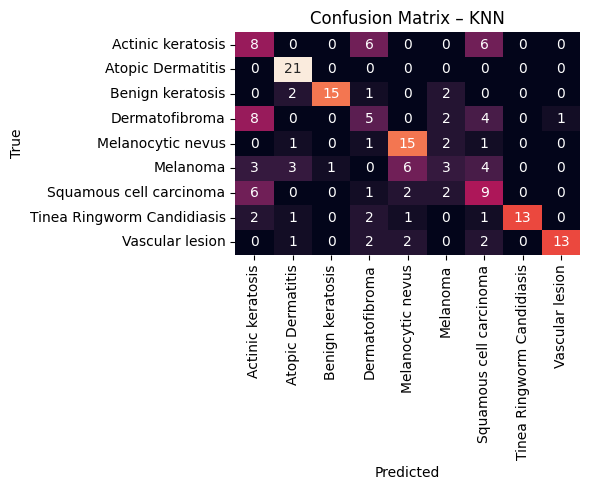

Training DecisionTree ...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best validation accuracy for DecisionTree: 0.4972
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.29      0.30      0.29        20
         Atopic Dermatitis       0.51      0.86      0.64        21
          Benign keratosis       0.86      0.60      0.71        20
            Dermatofibroma       0.38      0.55      0.45        20
         Melanocytic nevus       0.93      0.65      0.76        20
                  Melanoma       0.30      0.30      0.30        20
   Squamous cell carcinoma       0.18      0.20      0.19        20
Tinea Ringworm Candidiasis       0.69      0.45      0.55        20
           Vascular lesion       0.85      0.55      0.67        20

                  accuracy                           0.50       181
                 macro avg       0.55      0.50      0.51       181
              weighte

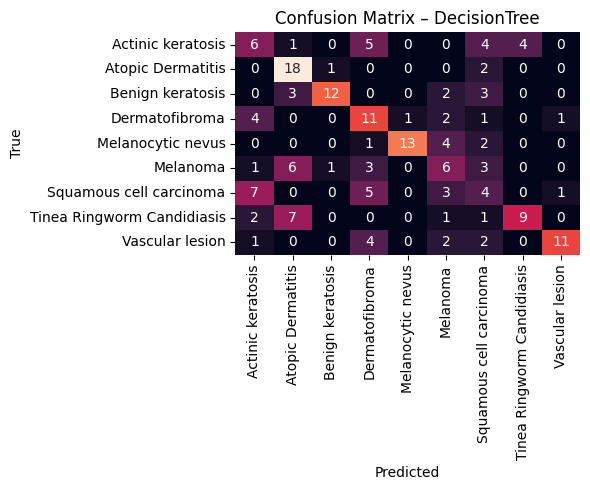

Training SVM ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best validation accuracy for SVM: 0.6188
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.40      0.50      0.44        20
         Atopic Dermatitis       0.67      0.95      0.78        21
          Benign keratosis       0.84      0.80      0.82        20
            Dermatofibroma       0.53      0.40      0.46        20
         Melanocytic nevus       0.64      0.80      0.71        20
                  Melanoma       0.46      0.30      0.36        20
   Squamous cell carcinoma       0.33      0.45      0.38        20
Tinea Ringworm Candidiasis       1.00      0.60      0.75        20
           Vascular lesion       1.00      0.75      0.86        20

                  accuracy                           0.62       181
                 macro avg       0.65      0.62      0.62       181
              weighted avg       0.65   

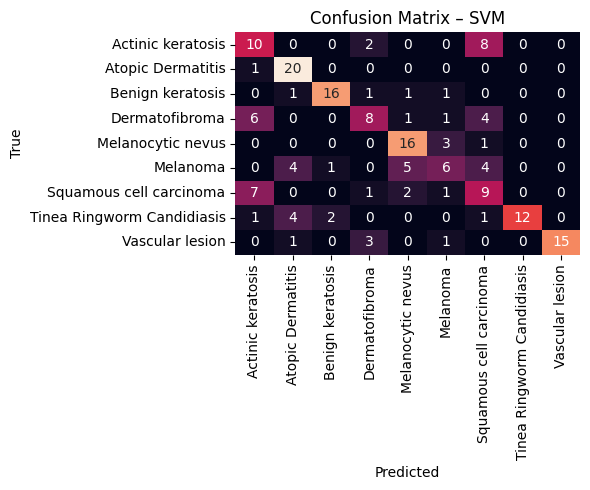

Training LogReg ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best validation accuracy for LogReg: 0.5359
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.36      0.60      0.45        20
         Atopic Dermatitis       0.59      0.90      0.72        21
          Benign keratosis       0.94      0.75      0.83        20
            Dermatofibroma       0.43      0.15      0.22        20
         Melanocytic nevus       0.56      0.75      0.64        20
                  Melanoma       0.11      0.05      0.07        20
   Squamous cell carcinoma       0.30      0.35      0.33        20
Tinea Ringworm Candidiasis       0.70      0.35      0.47        20
           Vascular lesion       0.75      0.90      0.82        20

                  accuracy                           0.54       181
                 macro avg       0.53      0.53      0.50       181
              weighted avg       0.

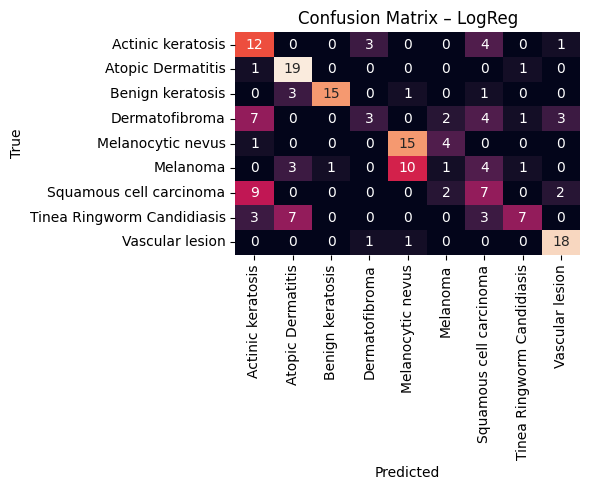

In [ ]:
# 9. Training and evaluation

def plot_confusion_matrix(true_labels: np.ndarray,
                          pred_labels: np.ndarray,
                          class_names: List[str],
                          title: str = "Confusion Matrix") -> None:
    """Plot a confusion matrix with readable labels."""
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Reload features from disk to make this cell standalone / restart-resistant
train_df = pd.read_csv(train_features_path)
val_df   = pd.read_csv(val_features_path)

X_train = train_df.drop('class', axis=1).values
y_train = train_df['class'].values

X_val = val_df.drop('class', axis=1).values
y_val = val_df['class'].values

# Standardize numeric features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)

# Encode labels
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)

# Define candidate estimators and hyperparameter grids
model_specs = {
    'KNN': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3,5,7],
            'weights': ['uniform','distance'],
            'metric': ['euclidean','manhattan'],
        }
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {
            'max_depth': [None,5,10,20],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,2,4],
        }
    ),
    'SVM': (
        SVC(probability=False, random_state=RANDOM_STATE),
        {
            'C': [0.1,1,10],
            'kernel': ['linear','rbf'],
            'gamma': ['scale','auto'],
        }
    ),
    'LogReg': (
        LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
        {
            'C': [0.1,1,10],
            'penalty': ['l2'],
        }
    ),
}

results = {}

for model_name, (estimator, param_grid) in model_specs.items():
    print(f"Training {model_name} ...")
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train_s, y_train_enc)

    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val_s)

    acc = accuracy_score(y_val_enc, y_val_pred)
    report = classification_report(y_val_enc, y_val_pred, target_names=le.classes_)

    print(f"Best validation accuracy for {model_name}: {acc:.4f}")
    print("Classification Report:")
    print(report)

    results[model_name] = {
        'model': best_model,
        'accuracy': acc,
        'classification_report': report,
    }

    plot_confusion_matrix(
        true_labels=y_val_enc,
        pred_labels=y_val_pred,
        class_names=list(le.classes_),
        title=f"Confusion Matrix – {model_name}"
    )

## 10. Evaluation Summary

This compact printout consolidates validation accuracy and detailed reports across the tuned models. The summary makes model comparison fast and transparent and sets the stage for selecting a baseline that balances accuracy, stability, and interpretability. Keeping this cell minimal improves readability when the notebook is used as a research portfolio artifact.


In [ ]:
# 10. Evaluation summary

for model_name, info in results.items():
    print(f"\n{model_name}")
    print(f"Validation Accuracy: {info['accuracy']:.4f}")
    print("Classification Report:")
    print(info['classification_report'])



KNN
Validation Accuracy: 0.5635
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.30      0.40      0.34        20
         Atopic Dermatitis       0.72      1.00      0.84        21
          Benign keratosis       0.94      0.75      0.83        20
            Dermatofibroma       0.28      0.25      0.26        20
         Melanocytic nevus       0.58      0.75      0.65        20
                  Melanoma       0.27      0.15      0.19        20
   Squamous cell carcinoma       0.33      0.45      0.38        20
Tinea Ringworm Candidiasis       1.00      0.65      0.79        20
           Vascular lesion       0.93      0.65      0.76        20

                  accuracy                           0.56       181
                 macro avg       0.59      0.56      0.56       181
              weighted avg       0.59      0.56      0.56       181


DecisionTree
Validation Accuracy: 0.4972
Classification 

## 11A. Visualization Utilities

A helper is provided to render side by side comparisons of original and preprocessed images. The function accepts lists of paths, enforces a fixed display size for consistency, and hides axes to emphasize qualitative differences. This visualization supports rapid checks that hair removal, inpainting, and smoothing behave as intended on diverse classes and lighting conditions.


In [ ]:
# 11A. Visualization utilities

def display_multiple_image_comparison(
    before_paths: List[str],
    after_paths: List[str],
    img_size: tuple = (224, 224)
) -> None:
    """
    Display qualitative before/after comparisons for multiple samples,
    illustrating the effect of the preprocessing pipeline.

    Parameters
    ----------
    before_paths : list of str
        File paths to the original (unprocessed) images.
    after_paths : list of str
        File paths to the corresponding preprocessed images (same ordering).
    img_size : tuple(int, int)
        Target size (width, height) for visualization only (not training).
    """
    num_images = min(len(before_paths), len(after_paths))
    if num_images == 0:
        print("No images provided for comparison.")
        return

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Normalize axes shape if only one row
    if num_images == 1:
        axes = np.array([axes])

    for i in range(num_images):
        before_img = Image.open(before_paths[i]).convert("RGB").resize(
            img_size, Image.Resampling.LANCZOS
        )
        after_img = Image.open(after_paths[i]).convert("RGB").resize(
            img_size, Image.Resampling.LANCZOS
        )

        # Original image
        axes[i, 0].imshow(before_img)
        axes[i, 0].set_title(f"Before Preprocessing #{i+1}")
        axes[i, 0].axis("off")

        # Preprocessed image
        axes[i, 1].imshow(after_img)
        axes[i, 1].set_title(f"After Preprocessing #{i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

## 11B. Qualitative Preprocessing Check

A single class is selected and a small batch of samples is visualized before and after preprocessing. The selection is adjustable for targeted inspection. This qualitative view verifies that black hat masking and inpainting do not introduce artifacts and that smoothing remains light enough to retain lesion borders. The display complements numerical evaluation by exposing corner cases in illumination or contrast.


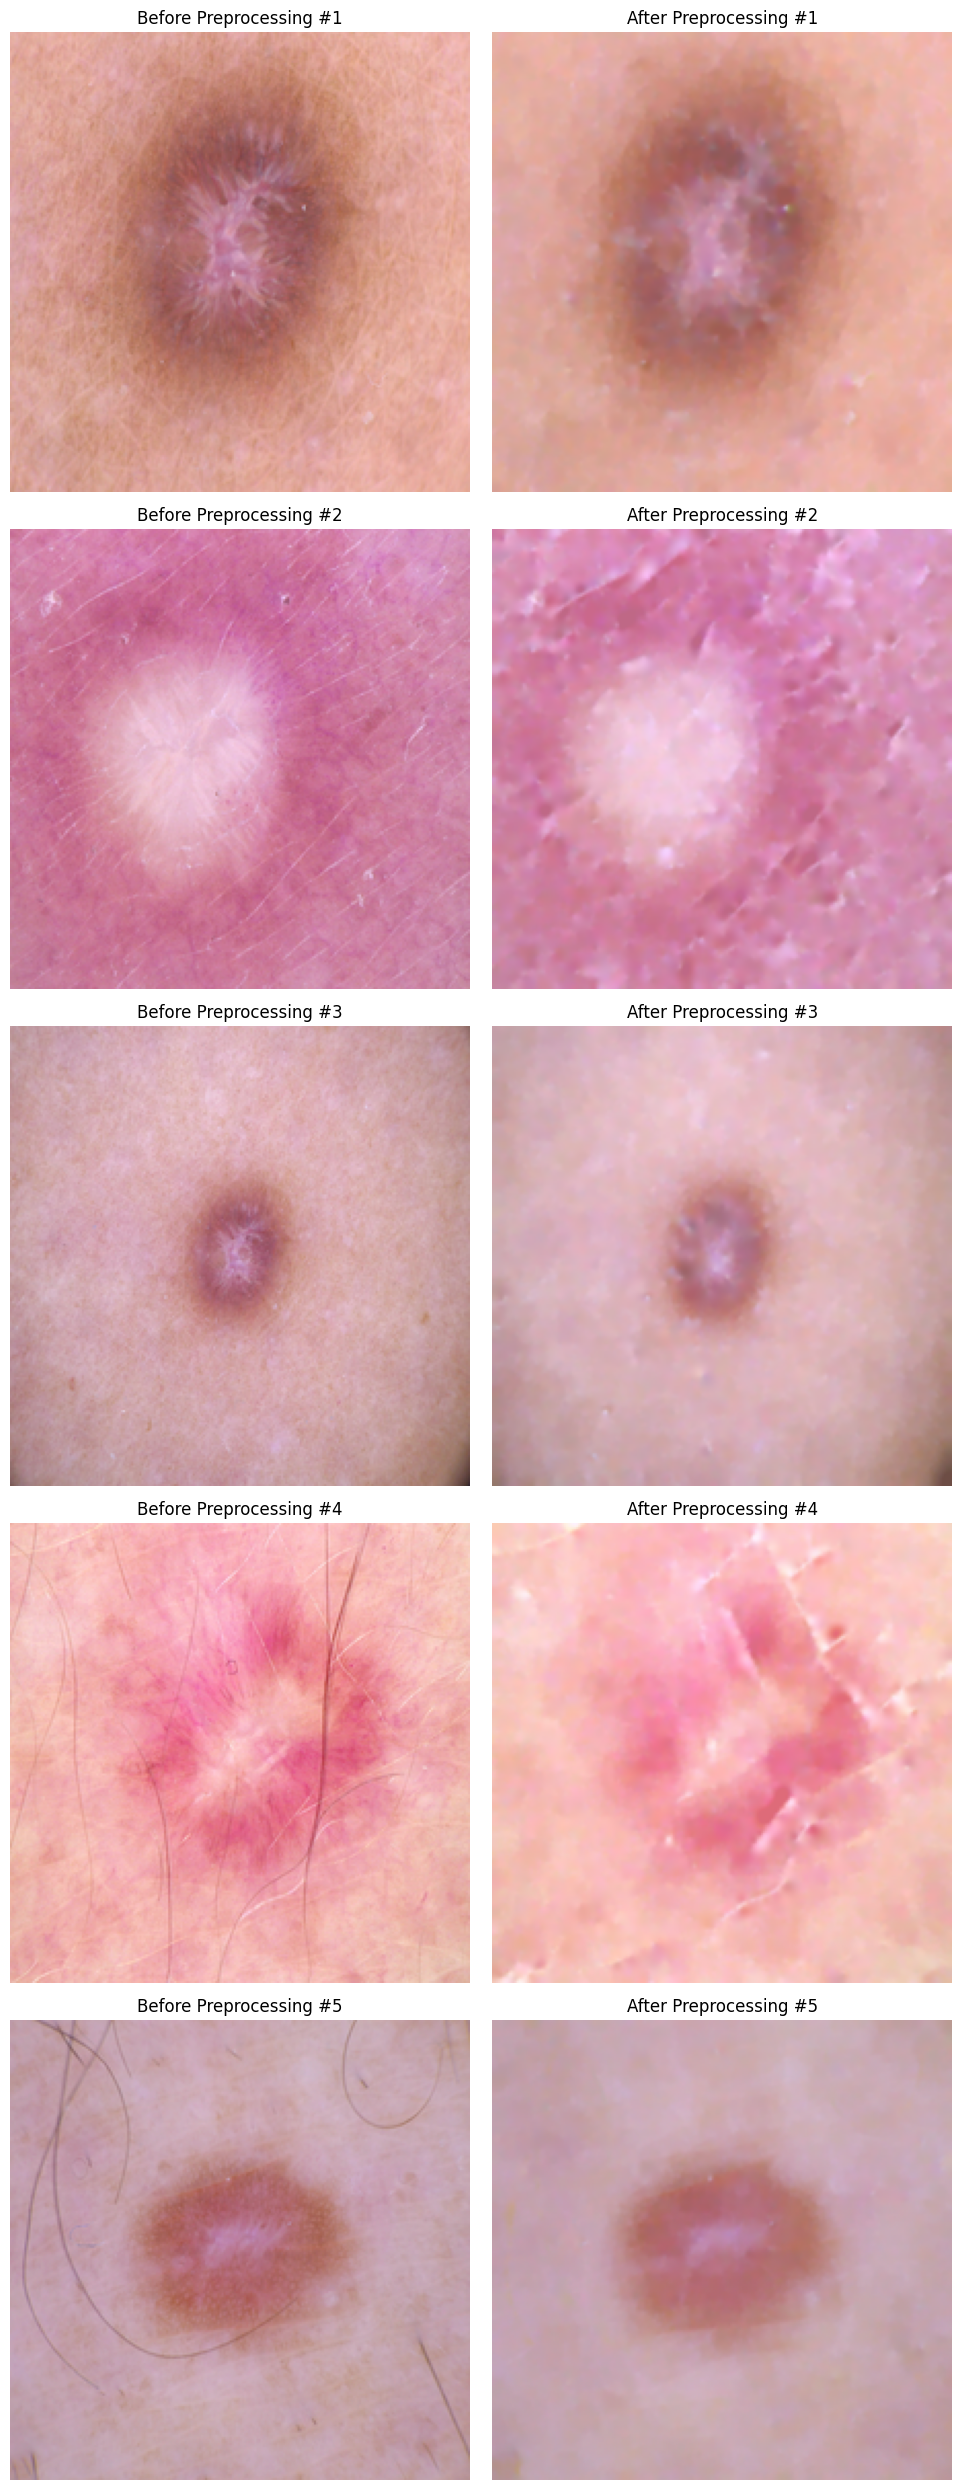

In [ ]:
# 11B. Qualitative preprocessing check (raw vs. cleaned images)

# Select one class directory for inspection
all_classes = sorted(os.listdir(RAW_TRAIN))
example_class = all_classes[3]  # can be changed manually for other classes

raw_class_dir  = os.path.join(RAW_TRAIN,  example_class)
proc_class_dir = os.path.join(PROC_TRAIN, example_class)

# Take a few samples from that class (up to 5 images)
raw_files  = sorted(os.listdir(raw_class_dir))[:5]
proc_files = sorted(os.listdir(proc_class_dir))[:5]

before_paths = [os.path.join(raw_class_dir,  f) for f in raw_files]
after_paths  = [os.path.join(proc_class_dir, f) for f in proc_files]

# Visualize side-by-side
display_multiple_image_comparison(before_paths, after_paths)


## 11C. Feature Distribution Histograms

Histogram plots summarize the empirical distributions of all numeric features in the training table. These plots reveal separability, heavy tails, and potential outliers. The view also validates the impact of standardization and helps spot features with low variance that may contribute little to discrimination. Using a grid layout keeps the overview compact while preserving per feature detail.


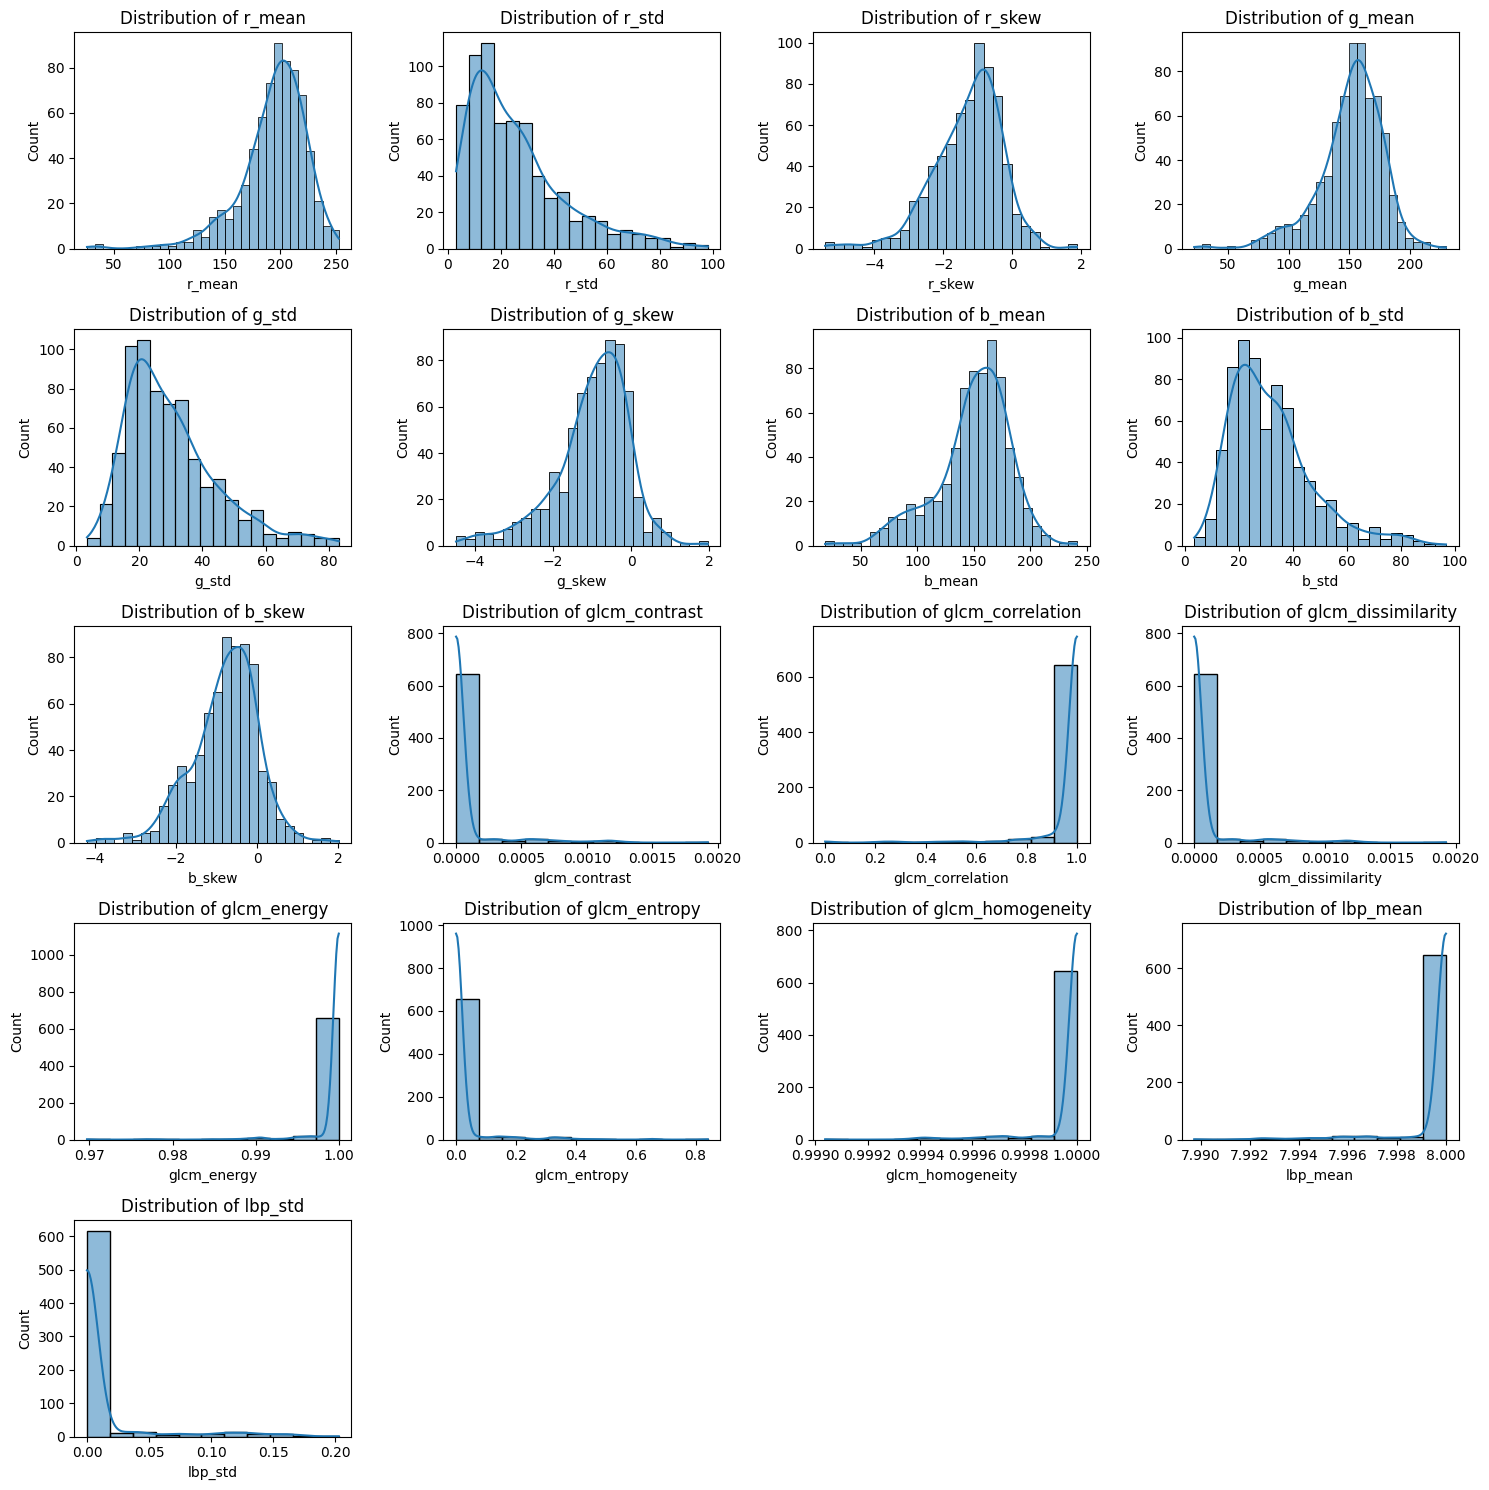

In [ ]:
# 11C. Feature distribution histograms

# Identify numeric feature columns (excluding the label column "class")
numeric_cols = [c for c in train_df.columns if c != "class"]
n_features = len(numeric_cols)

if n_features == 0:
    print("No numeric features found in train_df for histogram plotting.")
else:
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)

    plt.figure(figsize=(15, n_rows * 3))

    for i, col in enumerate(numeric_cols, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(train_df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


## 12. Results

Validation results across four model families on 181 images show that the SVM ranks first with accuracy 0.6188 and macro F1 0.62, followed by KNN with accuracy 0.5635 and macro F1 0.56. Logistic Regression reaches accuracy 0.5359 with macro F1 0.50, while Decision Tree records accuracy 0.4972 with macro F1 0.51. Macro and weighted averages remain close for all models, which indicates that performance is not driven solely by a dominant class and that per class behavior contributes meaningfully to overall scores.

Per class patterns are consistent with known difficulty. Atopic Dermatitis achieves high recall under SVM at 0.95 with F1 0.78. Benign keratosis remains strong under SVM with F1 0.82, and Vascular lesion reaches precision 1.00 with recall 0.75 and F1 0.86. Tinea Ringworm Candidiasis shows precision 1.00 with recall 0.60 and F1 0.75. Melanocytic nevus yields F1 0.71. Actinic keratosis sits at F1 0.44. Melanoma is challenging across models with SVM F1 0.36 and Logistic Regression F1 0.07. Squamous cell carcinoma and Dermatofibroma remain mid range with SVM F1 0.38 and 0.46. Confusion matrices are expected to show off diagonal mass among melanocytic nevus, benign keratosis, and melanoma, as well as between actinic keratosis and squamous cell carcinoma, reflecting overlapping texture and color cues.

Key readouts to cite:
- SVM accuracy 0.6188 with macro F1 0.62 on the validation split
- KNN accuracy 0.5635 with macro F1 0.56
- Logistic Regression accuracy 0.5359 with macro F1 0.50
- Decision Tree accuracy 0.4972 with macro F1 0.51
- High recall for Atopic Dermatitis under SVM at 0.95 and strong F1 for Vascular lesion at 0.86
- Low F1 for Melanoma across models, indicating a need for feature refinement or data curation


## 13. Insights

Several practical lessons emerge from the experiments. Preprocessing that removes hair and gently smooths noise improves texture stability without erasing lesion borders. Combining color statistics with GLCM and LBP provides complementary signals that simple classifiers can exploit. Grid search with modest ranges is sufficient to locate robust operating points for KNN, SVM, Logistic Regression, and a constrained Decision Tree. Confusion plots highlight which classes require either better descriptors or targeted augmentation.

Concise takeaways:
- Hair removal with inpainting and light Gaussian smoothing stabilizes downstream texture features
- Color moments and second order texture from GLCM pair well with local patterns from LBP
- Macro averages are more informative than accuracy alone under class imbalance


## 14. Responsible Use and Limitations

This notebook is a research and teaching artifact. It is not intended for clinical diagnosis or policy decisions. Predictions support analysis and must be reviewed by qualified personnel.

Scope and risks:
- Dataset coverage may not reflect real world imaging variability in devices, lighting, or skin tones
- Class imbalance can mask rare failure modes and can affect calibration
- Handcrafted features capture limited visual context compared to expert assessment
- No external test set is used and domain shift is not evaluated

Operational guidance:
- Keep a human in the loop for any decision that affects patient care
- Reevaluate performance when data acquisition conditions change
- Prefer macro oriented reporting and per class inspection when comparing versions


## 15. Conclusion

A compact classical pipeline with deterministic preprocessing, interpretable color and texture features, and tuned lightweight classifiers yields a clear and reproducible baseline for skin lesion categorization. Fixed image size, stable masking, and consistent feature order make the system easy to audit and simple to rerun on Google Colab or comparable environments. Reporting that centers macro metrics and confusion analysis keeps attention on minority classes and systematic errors rather than headline accuracy alone.

The baseline is suitable for research and teaching and establishes a practical foundation for further work that aims to improve robustness while retaining low computational cost.


## 16. Next Steps

Future work can extend this baseline while maintaining a modest footprint. Augmentation policies tailored to dermatology, such as slight color jitter, elastic micro transforms, or controlled blur, may improve generalization. Feature refinements worth testing include multi scale LBP, additional GLCM distances, and color space transforms such as HSV or Lab. A compact linear SVM on standardized features can be contrasted with a kernel SVM under the same split. Finally, external validation on a held out cohort would quantify sensitivity to domain shift.

Priorities to explore:
- Add targeted augmentation and measure the change in macro F1 and per class recall
- Compare HSV and Lab statistics against RGB moments under identical preprocessing
- Expand GLCM distances and evaluate the marginal gain over the current set
- Benchmark linear SVM versus RBF SVM with identical scaling and grids
- Assemble a small external test slice to estimate robustness under acquisition changes


## Author / Contact

**Rifky Setiawan**  
Undergraduate Student, Department of Computer Science  
Universitas Gadjah Mada (UGM), Indonesia   
Email: rifkysetiawan@mail.ugm.ac.id

